<a href="https://colab.research.google.com/github/drpOpZ/a4md_exam/blob/main/LZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
This work is the exam 


## Introduction
In a nutshell, a **compression algorithm** comprises an **encoding** procedure, which takes some input data and computes a more compact representation of it, and a corresponding **decoding** procedure, which reconstructs (at least partially) the original input from its compressed representation. As imaginable, they play a central role in *information theory*, since reduced file sizes generally ease data transmission and storage.

![coder/decoder](https://ars.els-cdn.com/content/image/3-s2.0-B9780750663106500040-f01-02-9780750663106.gif)  


Results from **Kolmogorov complexity theory**, which studies data compression from an abstract point of view, demonstrate that compressibility is an *undecidable problem*. In practice, this translates to the fact that no single algorithm can achieve the best compression for every possible input. We're faced with a no-free-lunch scenario, legitimating the [ample *buffet*](https://en.wikipedia.org/wiki/List_of_algorithms#Lossless_compression_algorithms) of available compression algorithms.

A broad distinction can be made between **lossless** and **lossy** compression algorithms: as the names suggest,
the former preserve all of the original information during the encoding phase, allowing for an exact reconstruction of the original data from its compressed counterpart during the decoding phase, while the latter discard part of the original signal (typically basing on use-case specific statistical analysis), so that the fidelity of the decompressed data is just sufficient to serve the intended purpose.

![lossless compression](https://ethw.org/w/images/6/6d/Compression_hierarchy.png)  
*Hierarchy of lossless compression algorithms.*

In this work we'll take a closer look at **LZ77** (a.k.a. *LZ1*), a general purpose, lossless compression algorithm that was first presented in 1977 in a paper [1] by *Abraham Ziv* and *Jacob Lempel* (hence its name). It is regarded as a [milestone](https://ethw.org/Milestones:Lempel-Ziv_Data_Compression_Algorithm,_1977) in the history of compression algorithms, as it gave birth to an entire family of LZ-derived algorithms, some of which are still widely used at the present date.  
The key idea behind the algorithm is using a fixed-size *sliding window* (or *circular buffer*) to process the data during both encoding and decoding, effectively making it an online algorithm: repeating patterns within the window are substituted with references to their previous occurrence.

### Content overview

After briefly introducing the **string notation** used in this work, we'll start reviewing the contents of the original LZ77 paper, presenting the **encoding and decoding procedures in detail**.  
We'll then pause the review to present a simple **python implementation** of the LZ77 encoding and decoding algorithms, following a quick demonstration to
test their correctedness and measure their performance empirically.  
Finally we'll get back to the paper, reviewing the **theoretical results** on the algorithm's performance.  
All the **referenced resources** can be found listed at the end of the notebook.

## Notation Remarks
- $\Sigma$ is a finite *alphabet* of cardinality $|\Sigma|$
- $\Sigma^*$ is the set of finite *strings* on $\Sigma$
- Srings are represented using capital letters e.g. $S,B\in \Sigma^*$
- $\varepsilon$ represents the *empty string*
- literal characters and strings will use the formatting $\texttt{a,b,0,...}$ 
- $A\cdot B$ is the *concatenation* of strings/characters/literals
- $A^n$ is the string obtained by concatenating $A$ with itself exactly $n$ times; in particular $A^n = \varepsilon$ if $n<1$

furthermore we shall use the following notation to represent a **substring**s:
$$S[i\stackrel{l}{...}j]$$
where 
- $i,j\in \{1,...,|S|\}$ are the indices of the first and last characters
- $l= \max\{j-i+1,0\}\geq 0$ is the length of the substring;

the latter definition allows us to interpret the case in which $i>j$ as $\varepsilon$; notice that it's sufficient to specify only two of $i,l,j$ to unambiguosly identify a substring: we shall exploit this redundancy and omit (at least) one of them, as is more convenient.  
We shall further simplify the notation by only specifying $i$ or $j$ (and the three dots) when referring to **suffix**es or **prefix**es of $S$ respectively.  
Furthermore, we shall use the notation $S[i]$ to address the $i$-th character of $S$ (i.e. substring of length 1).

Example:  
$$\begin{aligned} S &= \texttt{zivlempel}\\
S[4] = S[4\stackrel{1}{...}] = S[\stackrel{1}{...}4]&= \texttt{l}\\
S[\ldots4] &= \texttt{zivl}\\
S[4\ldots] &= \texttt{lempel}\\
S[2\ldots4] = S[\stackrel{3}{...}4] = S[2\stackrel{3}{...}] &= \texttt{ivl}\\
S[2\ldots1] = S[2\stackrel{0}{...}] = S[\stackrel{0}{...}1]&= \varepsilon
\end{aligned}$$

## LZ77 Algorithm

We will now introduce the concept of **reproducible extensions** and present LZ77 encoding and decoding procedures as detailed in the original paper.   
A decent effort was put in revisiting the notation in the attempt of making it as unambiguous as possible (although generally more cumbersome). 

### Definition: Reproducible Extension
Given $B\in \Sigma^*$, let $B[...j]$ be a *proper prefix* of $B$; for each $i\in \{1,...,j\}$ let

$$\text{L}_j(i,B) := \max \{l\in \{0,...,|B|-j\} : B[i\stackrel{l}{...}] = B[j+1\stackrel{l}{...}]\},$$

that is, the length of the longest substring of $B$ starting at $i\leq j$ and matching a prefix of $B[j+1 ...]$ (note that the two may overlap), and let

$$\text{L}_j(B) := \max_{i\leq j} \text{L}_j(i,B),$$

we thus define the **reproducible extension** of $B[...j]$ into $B$ as
$$\text{RE}_j(B) := B[j+1\stackrel{\text{L}_j(B)}{...}]\ .$$

Furthermore, it is useful to define the *pointer* $p_j$ to the rightmost occurence of $\text{RE}_j(B)$ as

$$
p_j(B) := \max \{p : \text{L}_j(p,B) =\text{L}_j(B)\}
$$
Note that when $\text{L}_j(B)=0$ (and thus $\text{RE}_j(B)=\varepsilon$) we have $p_j(B)=j$.

For any given $B$ and $j$, $\text{RE}_j(B)$ can be uniquely identified with the pair $(p_j(B),\text{L}_j(B))$.  

#### Example  
*(NOTE: $B$ is omitted for brevity)*
$$\begin{aligned} B &= \texttt{abacab}\underline{\texttt{d}}\texttt{abc}\\
\text{L}_7(1) = \text{L}_7(5) &= 2\\
\text{L}_7(2) = \text{L}_7(7) &= 0\\
\text{L}_7(3) &= 1\\
\text{L}_7 = \text{L}_7(5) &= 2\\
\text{RE}_7 &= \texttt{ab}\\
p_7 &= 5\\
\end{aligned}$$

### Encoding Algorithm

As mentioned in the opening paragrah, only a finite portion of the input data is processed during any step of the computation. This is accomplished by "sliding" a buffer $B$ of fixed size $\ell_b$ over the input stream $S$, computing $\text{RE}_{\ell_s}$ on that buffer minus the last character at a fixed index $\ell_s$ (= *search buffer size*) and storing the associated $(p_{\ell_s},\text{L}_{\ell_s})$ pair, along with the next character in the buffer. The sliding window is then "slided ahead" of the number of encoded characters (i.e. $\text{L}_{\ell_s}+1$) and the process is repeated until the whole input has been processed.

More precisely, let $B_i$ be the content of the *sliding window* at the beginning of step $i$, with $|B_i|=\ell_b=\ell_s + \ell_l \ \forall\ i$, where $\ell_l$ is the fixed *look-up buffer size*.  
The initial state of the buffer is

$$B_1 = \texttt{0}^{\ell_s} \cdot S[1\stackrel{\ell_l}{...}]$$

that is, initially it only cointains $\ell_s$ copies of some fixed padding character $\texttt{0}\in\Sigma$, followed by the first $\ell_l$ characters of $S$ (note: it is reasonable to assume that $S$ will have enough characters, otherwise some right padding can be applied).

The algorithm then computes for $i\geq 1$

$$\begin{aligned}
\pi_i &= p_{\ell_s}(B_i[...\ell_b-1]) - 1 &\in \{0,...,\ell_s-1\}\\
\lambda_i &= \text{L}_{\ell_s}(B_i[...\ell_b-1]) &\in \{0,...,\ell_l-1\}\\
c_i &= B_i[\ell_s+1+\lambda_i] &\in \Sigma\\
\end{aligned}$$

This triplet uniquely identifies the substring (a.k.a. *source word*)

$$S_i := B_i[\ell_s+1\stackrel{\lambda_i + 1}{...} ]=  S[i + \sum_{j<i}\lambda_j \stackrel{\lambda_i + 1}{...}],$$

hence its base-$|\Sigma|$ representation $C_i\in\Sigma^*$ effectively constitutes an encoding of this substring. We thus define the $i$-th *encoded word* of the input $S$ as

$$C_i := \langle\pi_i\rangle_{|\Sigma|} \cdot \langle\lambda_i\rangle_{|\Sigma|} \cdot c_i.$$

$\forall\ i,\ C_i$ can always be stored using exactly

$$\ell_c := |C_i| = \lceil\log_{|\Sigma|}\ell_s\rceil + \lceil\log_{|\Sigma|}\ell_l\rceil + 1 \geq 3$$

characters of $\Sigma$.

The only thing left to do is updating the buffer by sliding it forward, that is, removing $\lambda_i+1$ characters on the left and feeding in the next  characters of $S$ (as before, eventually adding some padding $\texttt{0}$s on the right if necessary):

$$B_{i+1} = B_i[\lambda_i+2\ldots] \cdot S[\ell_l + \sum_{j\leq i}(\lambda_j+1) \stackrel{\lambda_i + 1}{...}]$$

![encoding overview](https://github.com/drpOpZ/a4md_exam/blob/main/images/encode.png?raw=true)

Notice that it may happen that $\lambda_i + 1 < \ell_c$, that is, that a codeword takes more characters than those that it codes for (e.g. most surely when $i=1$ because the search buffer is full of padding characters); when $S$ is highly entropic or $\ell_s,\ell_l$ are chosen poorly this can happen so frequently that the encoded sequence turns up to be *inflated* rather than compressed in the process. Some possible tweaks to mitigate this problem include performing a preliminary analysis to find optimal values of $\ell_s,\ell_l$ and preceding codewords with a character or sequence that doesn't appear in $S$, so that the problematic segments can be left untouched.

That said, let's work out an example by hand to show that, despite the tricky notation, this encoding procedure is pretty intuitive.

#### Encoding Example

$$\begin{aligned}
\Sigma &= \{\texttt{0},\texttt{1},\texttt{2}\} &|\Sigma| = 3\\
S &= \texttt{1010112121210102}  &|S| = 16\\
\ell_b &= 18,\ \ell_s = 9,\ \ell_l=9\\
\ell_c &= \lceil\log_39\rceil + \lceil\log_39\rceil + 1 = 5
\end{aligned}$$

$$\begin{matrix}
i & B_i&\pi_i &\lambda_i &c_i &C_i\\
1 & \texttt{00000000}\underline{\texttt{0}}\,\texttt{101011212}
& 8 & 0 & \texttt{1} & \texttt{22 00 1}\\
2 & \texttt{00000000}\underline{\texttt{1}}\,\texttt{010112121}
& 7 & 4 & \texttt{1} & \texttt{21 11 1}\\
3 & \texttt{00010101}\underline{\texttt{1}}\,\texttt{212121010}
& 8 & 0 & \texttt{2} & \texttt{22 00 2}\\
4 & \texttt{00101011}\underline{\texttt{2}}\,\texttt{121210102}
& 7 & 5 & \texttt{0} & \texttt{21 12 0}\\
5 & \texttt{11212121}\underline{\texttt{0}}\,\texttt{102......}
& 7 & 2 & \texttt{2} & \texttt{21 02 2}\\
\end{matrix}$$

$$ C = \texttt{2200121111220022112021022},\ |C|=25$$

Yes, this example also demonstrates the "inflating problem". We'll get to see actual compression in a couple paragraphs, promise! 

### Decoding Algorithm
The decoding procedure is very straightforward and less resource demanding than its counterpart: while encoding requires matching strings to spot the longest repeated word, in this case we simply need to copy characters from a *decoding buffer* as instructed by the current block $C_i$ in order to reconstruct the corresponding source word $S_i$.  


The input file is read online, one block at a time, and we only need to keep the last $\ell_s$ decoded characters in our decoding buffer. The buffer is initially filled with the same padding character used during encoding.  
The sizes of the block's components must also be known by the decoding algorithm (e.g. passing $\ell_s, \ell_l$ and $|\Sigma|$ in input). 

We'll decode the result of the previous example to illustrate the process.

#### Decoding Example

$$\begin{aligned}
\Sigma &= \{\texttt{0},\texttt{1},\texttt{2}\} &|\Sigma| = 3\\
C &= \texttt{2200121111220022112021022} &|C|=25\\
\ell_s &= 8,\ \ell_c = 2 + 2 + 1\\
\end{aligned}$$


$$\begin{matrix}
i & B_i &C_i &\pi_i &\lambda_i &c_i  &S_i\\
1 & \texttt{000000000} & \texttt{22 00 1} & 8 & 0 & \texttt{1} & \texttt{1}\\
2 & \texttt{000000001} & \texttt{21 11 1} & 7 & 4 & \texttt{1} & \texttt{01011}\\
3 & \texttt{000101011} & \texttt{22 00 2} & 8 & 0 & \texttt{2} & \texttt{2}\\
4 & \texttt{001010112} & \texttt{21 12 0} & 7 & 5 & \texttt{0} & \texttt{121210}\\
5 & \texttt{112121210} & \texttt{21 02 2} & 7 & 2 & \texttt{2} & \texttt{102}\\
\end{matrix}$$

$$S = \texttt{1010112121210102},\ |S| = 16$$

## Implementation
We'll now take a look at a basic implementation of the encoding and decoding procedures of the LZ77 algorithm. The original paper limits to a theoretical presentation of the algorithm, hence the following design choices were taken to keep things reasonably simple:
- **naive string matching** is used to compute $\lambda_i$ during encoding
- **lookup and search buffer sizes are powers of 256**, so that we can represent them using an integer number of bytes (i.e. characters of our alphabet); this doesn't give us much play room for fine tuning the parameters, but spares us the additional complexity of working with single bits; their value shouldn't be set above 2 to keep execution time reasonable  
- **lookup and search buffer sizes are given in input to both encoding and decoding procedures**: ideally the encoder should compute the optimal values of $\ell_l$ and $\ell_s$ for each input file, while the decoder could read these values directly from the compressed output.

Without further ado, let's dig right into the code!

In [ ]:
# LZ77 ENCODING PROCEDURE

# import struct #for packing/unpacking encoded blocks
import os

# Encoding step: processes buffer, computes RE by repeated naive string matching
def compute_block_parameters(buff:bytearray,search_size:int):

  # assumes len(buff)>search_size, assert in main routine 
  lookahead_size = len(buff) - search_size

  # naive string matching 
  longest_match = 0
  pos = 0 
  for iii in range(search_size):
    matched_bytes = 0
    for jjj in range(lookahead_size-1):
      if (buff[iii+jjj]!=buff[search_size + jjj]):
        break
      matched_bytes+=1
    if (matched_bytes>=longest_match):
      pos = iii
      longest_match = matched_bytes

  next_char = buff[search_size+longest_match].to_bytes(1,'big')

  return pos, longest_match, next_char

# Read the input file and compress it into output file
def lz77_encode(input_filename,output_filename, search_bytes=1, lookahead_bytes=1,verbose=True):
  assert(input_filename != output_filename)
  assert(search_bytes>0 and lookahead_bytes>0)

  search_size = 256**search_bytes
  lookahead_size = 256**lookahead_bytes

  input_size = os.path.getsize(input_filename)

  buffer = bytearray(search_size)
  with open(input_filename,'rb') as f_in, open(output_filename,'wb') as f_out:

    buffer.extend(f_in.read(lookahead_size))

    bytes_encoded = 0
    blocks = 0
    while bytes_encoded < input_size:
      # compute and write next block
      pos, word_length, next_char = compute_block_parameters(buffer,search_size)

      f_out.write(pos.to_bytes(search_bytes,'big'))
      f_out.write(word_length.to_bytes(lookahead_bytes,'big'))
      f_out.write(next_char)

      # update buffer 
      shift = word_length+1
      buffer = buffer[shift:] + f_in.read(shift)
      bytes_encoded += shift

      # block statistics
      blocks += 1

  # screen output    
  if (verbose):
    output_size = os.path.getsize(output_filename)
    compression_ratio = output_size / input_size
    print("'" + input_filename + "' encoded into '" + output_filename +"'\n",
          "\tInput Size:\t\t", input_size, " B"," (= encoded? ",bytes_encoded == input_size,")\n",
          "\tOutput Size:\t\t", output_size, " B\n",
          "\tCompression Ratio:\t", compression_ratio, "\n",
          "\tOutput Blocks:\t\t", blocks, "\n",
          "\tAvg Bytes per Block:\t", input_size/blocks)

In [ ]:
# LZ77 DECODING PROCEDURE

# Decoding step: get source word from buffer and block parameters
def decode_block(buff:bytearray,pos,length,nextch:bytes):
  
  #it is assumed that 0 <= pos < len(buff)
  if length == 0:
    return nextch

  elif pos + length <= len(buff):
    return buff[pos : pos+length] + nextch
  
  else:
    # overlap case
    return buff[pos:]*(length//(len(buff)-pos))+\
           buff[pos:pos+(length%(len(buff)-pos))] +\
           nextch

# decodes input_filename into output_filename with given parameters
def lz77_decode(input_filename,output_filename, search_bytes=1, lookahead_bytes=1):
  assert(search_bytes>0 and lookahead_bytes>0)
  
  buffer = bytearray(256**search_bytes)

  with open(input_filename, "rb") as f_in, open(output_filename, "wb") as f_out:
    cw_bytes = search_bytes + lookahead_bytes + 1
    codeword = f_in.read(cw_bytes)
    while ( codeword != b'' ):
      
      pos = int.from_bytes(codeword[:search_bytes],'big')
      length = int.from_bytes(codeword[search_bytes:-1],'big')
      nextch = codeword[-1:]

      decoded_word = decode_block(buffer,pos,length,nextch)

      f_out.write(decoded_word)

      buffer = buffer[length+1:] + decoded_word
      codeword = f_in.read(cw_bytes)

## Does it work?
Before inquiring on the complexity and performance of the algorithm, let's make some test to ensure that it works as expected.

First let's test the subroutines that compute the codeword parameters and decode the single codewords:

In [ ]:
# UNIT TEST: COMPUTE_BLOCK 
# Checking that the encoding sub-routine is working properly
for buff, search_size, expected_out in [[b'020177777',4,(3,0,b'7')],  # no match --> (3,0,b'7')
                                        [b'020107777',4,(2,1,b'7')],  # 1 match  --> (2,1,b'7')
                                        [b'001010101',4,(2,4,b'1')]]: # 4 match w/ overlap --> (2,4,b'1') 
  actual_out = compute_block_parameters(buff, search_size)
  print("compute_block_parameters(",buff,",", search_size,")=", actual_out, '==', expected_out, '? ',actual_out == expected_out)

compute_block_parameters( b'020177777' , 4 )= (3, 0, b'7') == (3, 0, b'7') ?  True
compute_block_parameters( b'020107777' , 4 )= (2, 1, b'7') == (2, 1, b'7') ?  True
compute_block_parameters( b'001010101' , 4 )= (2, 4, b'1') == (2, 4, b'1') ?  True


In [ ]:
# UNIT TEST: DECODE_BLOCK
# Checking that decoding sub-routine is working properly
for buff, pi_i, lambda_i, next_c, expected_out in [[b'1234',3,0,b'7', b'7'],        # length 0    b'7'
                                                   [b'1234',2,2,b'7', b'347'],      # no overlap  b'347'
                                                   [b'1234',2,6,b'7', b'3434347']]: # overlap     b'3434347'
  actual_out = decode_block(buff, pi_i, lambda_i, next_c)
  print("decode_block(",buff,",", pi_i,",", lambda_i,",", next_c, ")= ",actual_out, '==', expected_out, '? ',actual_out == expected_out)

decode_block( b'1234' , 3 , 0 , b'7' )=  b'7' == b'7' ?  True
decode_block( b'1234' , 2 , 2 , b'7' )=  b'347' == b'347' ?  True
decode_block( b'1234' , 2 , 6 , b'7' )=  b'3434347' == b'3434347' ?  True


The tests look good, let's see how the main routines deal with a real task.  
We'll download the HTML page of the [wikipedia entry for LZ77 and LZ78](https://en.wikipedia.org/wiki/LZ77_and_LZ78), encode and then decode it.  
We're interested in verifying

- that the encoded->decoded file matches the original
- that the encoded file is smaller than the original

We'll use a simple routine that compares the files byte-per-byte to assess the first, while the verbose output of `lz77_encode` shall take care of the second

In [ ]:
# CORRECTEDNESS TEST

# routine for checking that two files are equal
def chk_files(fname1, fname2):
  same = True
  with open(fname1, "rb") as f1, open(fname2, "rb") as f2:
    while (same):
      c1 = f1.read(1)
      c2 = f2.read(1)
      if (c1 == b'' and c2 == b''):
          break
      same = c1 == c2

  return same

In [ ]:
!curl https://en.wikipedia.org/wiki/LZ77_and_LZ78 --output lzwiki.html

# encode the page
lz77_encode('lzwiki.html', 'lzwiki.lz',1,1)

# decode the compressed file and check if it matches the original
lz77_decode('lzwiki.lz', 'lzwiki_dec.html',1,1)
print("\nDid 'lzwiki.lz' survive the encoding+decoding procedure?",chk_files('lzwiki.html','lzwiki_dec.html'))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88516  100 88516    0     0   502k      0 --:--:-- --:--:-- --:--:--  502k
'lzwiki.html' encoded into 'lzwiki.lz'
 	Input Size:		 88516  B  (= encoded?  True )
 	Output Size:		 65757  B
 	Compression Ratio:	 0.7428826426860681 
 	Output Blocks:		 21919 
 	Avg Bytes per Block:	 4.038322916191432

Did 'lzwiki.lz' survive the encoding+decoding procedure? True


The test output shows us that we succesfully managed to reduce the original file size and that the decompressed file matches the input.  
We can thus end this section answering *Yes* to the question in the title.

## Complexity estimation

We'll now attempt to work-out the time complexity of the encoding and decoding procedures.

In the following $N=|S|$ while $N_c$ is the number of encoded words, so that

$$N = \sum_{i=1}^{N_c} (\lambda_i+1)$$

### Encoding

The computation of a the $i$-th codeword takes exactly $\ell_s$ steps (outer `for` in `compute_block_parameters`), each performing $O(\lambda_i+1)$ operations (inner `for` and max update):

$$T_{es}(i) = O(\ell_s (\lambda_i+1)),\qquad i=1,\,\ldots\,,N_c$$

Actually 

$$T_{es}(i) = \sum_{j=1}^{\ell_s}\Theta(m_{i,j}),\qquad 1\leq m_{i,j} \leq \lambda_i+1 \leq \ell_l$$

The main routine takes an initial $\Theta(\ell_b)$ to initialize the buffer, then at each of the $N_c$ steps of the `while` loop it takes 
- $T_{es}(i)$ ops to compute $C_i$
- $\Theta(\ell_c)$ ops to write it onto the output file and
- $\Theta(\lambda_i+1)$ operations to update the buffer

summing it up we have

$$\begin{aligned}
T_e&= \Theta(\ell_b) + \sum_{i=1}^{N_c} \left[T_{es}(i) + \Theta(\ell_c) + \Theta(\lambda_i+1)\right]\\
&=\Theta(\ell_b) + \Theta(N_c\ell_c) + \sum_{i=1}^{N_c} \left[O(\ell_s(\lambda_i+1)) + \Theta(\lambda_i+1)\right]\\
&\leq \Theta(\ell_b) + \Theta(N_c\ell_c) + O(N(\ell_s+1))\\
&\leq O(N(\ell_c+\ell_s+1) )
\end{aligned}$$

that is, 

This is a very rough upper bound, as in practice both $T_{es}$ and, consequently, $T_e$ greatly depend on the average encoded word length, which, in turn, depends both on the choice of the encoding parameters ($\ell_s$ and $\ell_l$) and on the intrinsic quality of the input data.

Tightening this upper bound would either require a deeper discussion on topics of compression theory or more knowledge of the specific source whose strings we're trying to compress.  
Since neither appear appropriate for the scope of this work we'll settle with this estimate, and rather take an experimental approach to test the performance of this specific implementation (see the following section).

Finally, this estimate doesn't take into account the additional complexity due to estimate the optimal $\ell_s, \ell_l$, which, in the simplest instance, could consist in running a grid search, hence adding another linear multiplier to the final complexity.

### Decoding procedure

In this case no string matching must be performed, hence we can expect the decoding process to be quicker.  
Decoding a single codeword takes a constant time $\Theta(\ell_c)$ to read the codeword, plus $\Theta(\lambda_i +1)$ to decode it. Decoding the entire input file simply consists in running the subroutine for each codeword:

$$T_d = \sum_{i=1}^{N_c} \Theta(\ell_c) + \Theta(\lambda_i +1) = O(N)+O(N_c\ell_c)\leq O((\ell_c + 1) N)$$

Once again the complexity depends linearly on the input size and the number of codewords. The same considerations done for the encoding procedure apply.  

In [ ]:
# Time Complexity test
import time
import random

repetitions = 10
scores = []
for iii in range(7):
  in_size = 2**(10+iii)
  score = []
  print(in_size, end=':\t')

  for variability in [1.,.9,.8,.7,.6,.5,"all"]:
    avg_encoding_time = 0
    avg_outsize = 0
    avg_decoding_time = 0
    for r in range(repetitions):

      # generate randomized string
      with open('in.bin','wb') as f:
        if variability == "all":
          f.write( random.getrandbits(8*in_size).to_bytes(in_size,'big'))
        else:
          for byte in random.choices([b'\x22',b'\x33'],cum_weights=[variability,1], k=in_size):
            f.write( byte )

      # collect encoding/decoding statistics
      t_start = time.time()
      lz77_encode('in.bin','out.bin',1,1,verbose=False)
      t_end = time.time()
      avg_encoding_time += t_end-t_start

      t_start = time.time()
      lz77_decode('out.bin','dec.bin',1,1)
      t_end = time.time()
      avg_decoding_time += t_end-t_start

      avg_outsize += os.path.getsize('out.bin')
    
    # compute averages and store results
    avg_encoding_time /= repetitions
    avg_outsize /= repetitions
    avg_decoding_time /= repetitions

    score.append([avg_outsize,avg_encoding_time,avg_decoding_time])
    
    print([round(stat,3) for stat in score[-1]], end='\t')

  print('')
  scores.append([in_size,score])

1024:	[15.0, 0.038, 0.0]	[160.2, 0.015, 0.0]	[249.0, 0.017, 0.0]	[312.0, 0.018, 0.0]	[346.2, 0.019, 0.0]	[356.4, 0.02, 0.0]	[1974.6, 0.083, 0.001]	
2048:	[27.0, 0.085, 0.0]	[313.5, 0.032, 0.001]	[480.9, 0.033, 0.0]	[594.9, 0.036, 0.001]	[660.3, 0.038, 0.001]	[679.5, 0.037, 0.001]	[3855.0, 0.164, 0.002]	
4096:	[51.0, 0.183, 0.0]	[598.8, 0.063, 0.001]	[931.8, 0.066, 0.001]	[1160.7, 0.07, 0.001]	[1301.7, 0.074, 0.001]	[1340.7, 0.073, 0.001]	[7610.7, 0.31, 0.004]	
8192:	[99.0, 0.374, 0.0]	[1170.0, 0.124, 0.001]	[1848.0, 0.135, 0.001]	[2308.8, 0.14, 0.002]	[2577.6, 0.144, 0.002]	[2661.6, 0.146, 0.002]	[15101.4, 0.618, 0.008]	
16384:	[195.0, 0.751, 0.0]	[2327.7, 0.249, 0.002]	[3716.1, 0.264, 0.002]	[4599.3, 0.278, 0.003]	[5120.7, 0.288, 0.003]	[5290.5, 0.291, 0.003]	[30113.7, 1.224, 0.015]	
32768:	[387.0, 1.513, 0.001]	[4654.8, 0.493, 0.003]	[7376.7, 0.527, 0.005]	[9200.7, 0.552, 0.005]	[10230.9, 0.572, 0.006]	[10551.9, 0.578, 0.006]	[60141.6, 2.436, 0.03]	
65536:	[771.0, 3.042, 0.001]	[9241

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


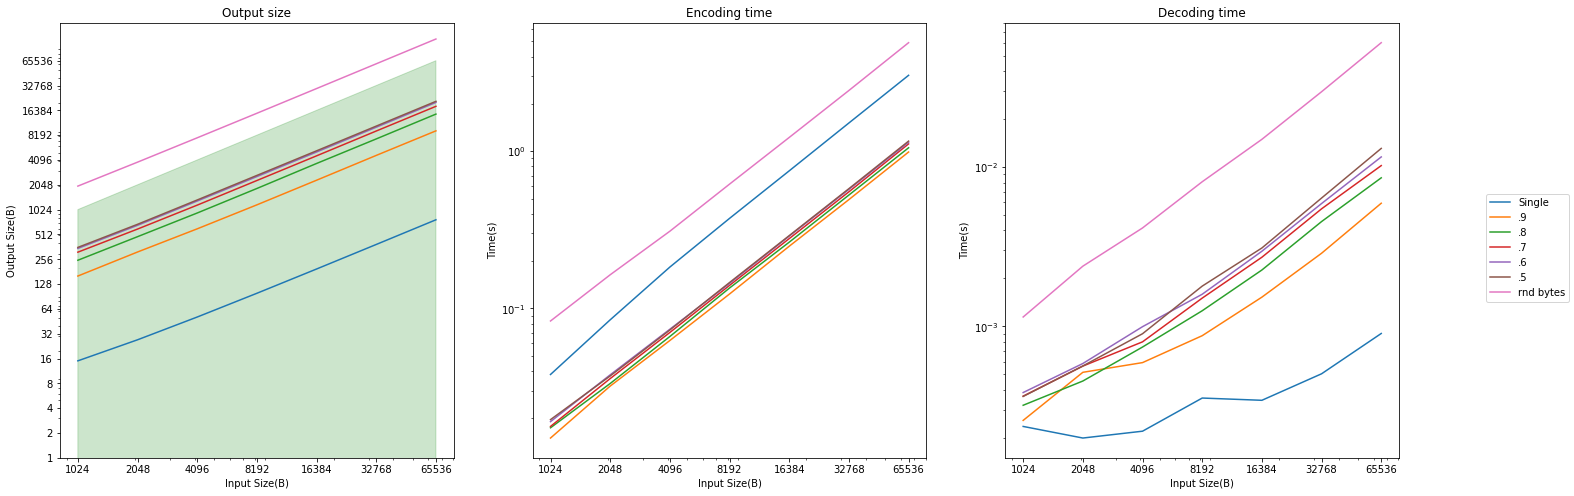

In [ ]:
# Plot timing results
import matplotlib
import matplotlib.pyplot as plt

X = [size for size,data in scores]

legend_handles = []
legend_labels = ["Single", ".9", ".8",".7",".6",".5","rnd bytes"]

fig,axes = plt.subplots(ncols=3,figsize=(24,8))
# log-log size vs enc
for title, data_index in [["Output size",0],["Encoding time",1],["Decoding time",2]]:
  
  axes[data_index].set_title(title)
  axes[data_index].set_yscale('log')
  axes[data_index].set_xscale('log')

  for variability in range(7):
    Y = [data[variability][data_index] for size,data in scores]
    h = axes[data_index].plot(X,Y)
  
  if len(legend_handles)<7:
    legend_handles.append(h)

  # in_size reference for out_size plot
  if data_index == 0:
    axes[data_index].fill_between(X,[0 for x in X],X,color='green',alpha=.2)
    # axes[data_index].plot(X,X,ls="--",color='black',lw=.5)
    axes[data_index].set_ylabel("Output Size(B)")
    axes[data_index].set_yticks([2**(ex) for ex in range(17)])
    axes[data_index].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

  else:
    axes[data_index].set_ylabel("Time(s)")

  axes[data_index].set_xlabel("Input Size(B)")
  axes[data_index].set_xticks(X)
  axes[data_index].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.legend(legend_handles,labels = legend_labels, loc="right")
plt.show()

## Theoretical Results
From LZ77 paper:
- D:source model and h-parameters
- D:compression ratio, BV
- L: CBV lower bound
- L: CVB lower bound
- T: crat upper bound
- T: r0 upper bound  

## References

Jacob Ziv, Abrham Lempel - *A Universal Algorithm For Sequential Data Compression* - 1977  
https://www.sciencedirect.com/topics/computer-science/compression-algorithm  
https://ethw.org/History_of_Lossless_Data_Compression_Algorithms  
https://www.devdungeon.com/content/working-binary-data-python